In [1]:
import tensorflow as tf
import keras
%load_ext autoreload
%autoreload 2
from grad import *
from model import *
import numpy as np


# I check autograd libraries

In [ ]:
x1 = Number(1)
x2 = Number(2)
x3 = Number(3)
x4 = Number(4)
x5 = Number(5)

y = (x1+x2)*x5 - x3
top_sorted = topo_sort(y)
print(top_sorted)

y.null_gradients()

for num in top_sorted:
    num.backprop_single()
    
print([(i.grad, i) for i in top_sorted])

y.null_gradients()
y.backprop()

print( [(i.grad, i) for i in top_sorted], "key")

# data getting

In [2]:

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz", )


# Keras Model

In [17]:
def get_flat_dataset(raw_x, raw_y):
  raw_x = raw_x / 255
  dataset = tf.data.Dataset.from_tensor_slices((raw_x.flatten().reshape(-1, 28*28), raw_y))
  return dataset

In [19]:
flat_train = get_flat_dataset(x_train, y_train)
flat_test = get_flat_dataset(x_test, y_test)

In [20]:
inputs = keras.Input(shape=((28* 28,)))
x = keras.layers.Dense(4)(inputs)
x = keras.layers.Dense(8)(x)

outputs = keras.layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [23]:
model.compile(loss="sparse_categorical_crossentropy", #labels appear to be from one to ten so i think this the right loss
              optimizer="rmsprop",
              metrics=['accuracy'])


history = model.fit(flat_train.take(1000).batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE), epochs=20,
                      validation_data=(flat_test.batch(32, drop_remainder = True).prefetch(tf.data.AUTOTUNE)),
                      )


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.2280 - loss: 2.1939 - val_accuracy: 0.4062 - val_loss: 1.8811
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4745 - loss: 1.7814 - val_accuracy: 0.4897 - val_loss: 1.6118
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5416 - loss: 1.5029 - val_accuracy: 0.5407 - val_loss: 1.4174
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5895 - loss: 1.2959 - val_accuracy: 0.5815 - val_loss: 1.2734
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6483 - loss: 1.1378 - val_accuracy: 0.6119 - val_loss: 1.1651
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6895 - loss: 1.0158 - val_accuracy: 0.6379 - val_loss: 1.0844
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7138 - loss: 0.9219 - val_accuracy: 0.6550 - val_loss: 1.0242
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7386 - loss: 0.8489 - val_accuracy: 0.6733 - v

# My model


In [3]:
def batch(x, y, batch_size=32):
    if len(x) % batch_size != 0:
        x = x[:batch_size * (len(x)//batch_size)]
        y=y[:batch_size*(len(x)//batch_size)]
    return np.array_split(x, len(x) / batch_size, axis=0), np.array_split(y, len(y)/batch_size, axis=0)

In [4]:
def fix_data(x, y):
    x = x.reshape(x.shape[0], 28*28)/255
    test = np.zeros((x.shape[0], 10))
    test[np.arange(x.shape[0]),y] = 1
    return (x, test)

In [20]:
fixed_x, fixed_y = fix_data(x_train[:10000], y_train[:10000])
b_x , b_y = batch(fixed_x, fixed_y, 1)

ERROR! Session/line number was not unique in database. History logging moved to new session 106


In [8]:
test = np.arange(20).reshape(2,2,5)
test2 = np.arange(20).reshape(2,2,5)

In [9]:
print(2 * test * test2)

[[[  0   2   8  18  32]
  [ 50  72  98 128 162]]

 [[200 242 288 338 392]
  [450 512 578 648 722]]]


In [10]:
print(np.sum(test))

190


In [21]:
my_model = Model(28*28, 10, [4, 8])
for _epoch in range(20):
    my_model.train_epoch(b_x, b_y, lr=10e-2)

ERROR! Session/line number was not unique in database. History logging moved to new session 107
mse Number(2.475584667078632)


RecursionError: maximum recursion depth exceeded while calling a Python object

In [17]:
#Holy debugging time
def np_number(k):
    return np.array([Number(i) for i in range(k)])
test = np_number(20).reshape(4, 5)
test2 = np_number(20).reshape(4, 5)

a = test[0][3] * test2[0][2]
print(topo_sort(a))

[Number(6), Number(2), Number(3)]


In [5]:
a = Number(2)
print(isinstance(a,  (Number, int, float, np.generic)))
Number(1) * Number(2)

True


Number(2)

# Comparison!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


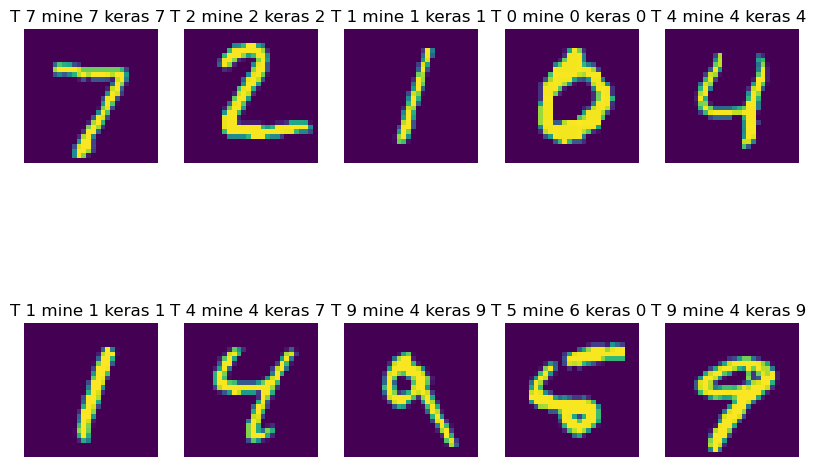

In [39]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

fig = plt.figure(figsize=(10, 7))
pic = 1
for i, img in enumerate(x_test[:10]):
  plt.subplot(2, 5, pic)
  plt.axis('off')
  predicted = my_model.fd(img.flat)
  keras_pred = model.predict(img.reshape(1, 28*28))
  plt.title(f"T {y_test[i]} mine {np.argmax(predicted)} keras {np.argmax(keras_pred)} ")
  plt.imshow(img)
  pic+= 1
plt.show()
#60% acc. Considering this is from nearly scratch not terrible 

# Reasons my model is kind of terrible and how to improve.
1. Slow. Still not 100% sure where the computation comes from. (but ima guess backprop) To do: Go figure that out.
2. Too little training data (This will be fixed with slow otherwise it would take days to train)
3. No batching. Need to figure that out too. (and how backprop works with batching)
4. No rmsprop. I don't even know where to start on that one.
5. No validation data. Yet.